# Physical Activity Classification

# Introduction

## Project Overview
The Colibri Wireless unit, represents a significant advancement in inertial measurement technology. It consists of three integrated sensors to measure acceleration, angular rate, and magnetic field, along with separate sensors for temperature and orientation. In this project, focus is to harness the potential of the Colibri unit to classify different physical activities accurately.

## Research Objective
The primary objective of this research is to develop a robust predictive model using machine learning techniques. This model will utilize the data gathered from the IMUs and heart-rate monitors to distinguish between various physical activities such as walking, cycling, and playing football. Successful classification and prediction of these activities will not only demonstrate the effectiveness of the Colibri unit but also provide actionable insights for its optimization in real-world health and fitness applications.

## Data Description
The study involves data collected from nine subjects who each participated in 12 core physical activities, with some conducting an additional six. The data, stored in individual .dat files, contains 54 attributes including timestamps, activity IDs, heart rate measurements, and IMU readings from sensors attached to the wrist, chest, and ankle.

## Hypothesis:
It is hypothesized that by examining the changes in heart rate and specific readings from motion-tracking sensors (IMUs), different physical activities can be accurately identified. It is assumed that unique patterns are exhibited by each physical activity, such as walking, running, or cycling. These patterns, characterized by variations in heart rate and specific movements, are captured by motion sensors (IMUs) attached to the hand, chest, and ankle. The aim is to analyze these distinct signatures and develop a predictive model. This model will not only differentiate between various activities but also demonstrate the effectiveness of the Trisivio Colibri Wireless unit in capturing these nuances, as compared to its competitors.

The aim is to prove the effectiveness of the Trivisio Colibri Wireless unit. The successful identification of activities using data from this unit would demonstrate its ability to accurately capture key health and movement information.

Information gathered from IMUs is the starting point. These advanced devices are capable of recording human movement in fine detail. Readings are encompassed from three distinct points of wear: the hand, chest, and ankle, providing a comprehensive view of physical activity. The dataset is structured to include 'time', 'activityID', and 'heart rate', along with numerous sensor readings from the IMUs, named 'IMU_hand_x', 'IMU_chest_x', and 'IMU_ankle_x', where 'x' ranges from 1 to 17.

The layout of the data is initially set up to match the detailed structure of the information gathered. Data is loaded and prepared from a collection of .dat files, each representing a piece of a larger puzzle in this study. These parts are combined into a single large data frame, with careful attention paid to maintaining the correct order and quality of the sensor records.

In navigating the preprocessing phase, a decision is made to discard transient activities, identified by 'activityID=0', as they are not contributory to the core objective of the analysis. Attention is then directed towards addressing missing values within the dataset. Given the critical importance of complete data for accurate modeling, missing values are imputed with the mean of their respective columns, thus ensuring a robust foundation for the subsequent analytical processes.

In [21]:
# Installing the SHAP library for model explanation
# SHAP is used for understanding the output of machine learning models
!pip install shap

# Upgrading scikit-learn to the latest version
# scikit-learn is a core machine learning library in Python, used for data preprocessing, model building, and evaluation
!pip install --upgrade scikit-learn

# Upgrading the imbalanced-learn library
# imbalanced-learn provides tools for dealing with class imbalance in machine learning, especially useful for datasets where some classes are underrepresented
!pip install --upgrade imbalanced-learn

# Installing the XGBoost library
# XGBoost is an efficient and popular library for gradient boosting, used for building high-performance classification models
!pip install xgboost

!pip install nbconvert

In [2]:
# Importing necessary libraries for data analysis and machine learning
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating plots and visualizations
import seaborn as sns  # For high-level visualization
import shap  # For explaining machine learning models
import os  # For interacting with the operating system
import glob  # For file pathnames matching
import warnings  # For warning control



# Importing machine learning tools from scikit-learn
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder  # For data preprocessing
from sklearn.feature_selection import SelectKBest, chi2  # For feature selection
from sklearn.model_selection import train_test_split, GridSearchCV  # For model selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score  # For model evaluation
from sklearn.ensemble import RandomForestClassifier  # For the random forest model
from imblearn.over_sampling import SMOTE  # For handling class imbalance
from xgboost import XGBClassifier  # For the XGBoost model

# Suppressing warnings for cleaner output
warnings.filterwarnings('ignore')

#  Data Overview

The Trivisio Colibri Wireless unit's performance is assessed through real-world activity data, drawn from:

- **Protocol Activities**: Standard exercises, providing baseline performance data.
- **Optional Activities**: Extra exercises to broaden the dataset for deeper analysis.

Data, recorded in .dat files, represents individual activity sessions. These files create an extensive dataset that includes timestamps, activity classification, heart rate in bpm, and IMU readings from the hand, chest, and ankle. These details are crucial for activity recognition and analysis. IMU data is especially vital as it showcases the unit's ability to track movement, a key differentiator from competitors.

The following section first asks dataset's filepath from user and combine data from the 'protocol' and 'optional' datasets, construct a comprehensive view of physical activity across a varied sample of individuals and exercises. This amalgamated dataset stands as the bedrock upon which we will build and refine our predictive models.

In [3]:
import os
import pandas as pd
import glob

# Function to load data from a given directory
def load_data(directory):
    # Create a pattern to match all .dat files in the provided directory
    all_files = glob.glob(os.path.join(directory, "*.dat"))
    # Initialize an empty list to store DataFrames
    df_list = []

    # Loop through each file path in the list of .dat files
    for file in all_files:
        # Print the file being read as a debug message
        print("Reading file:", file)
        # Read the data file into a DataFrame with predefined column names
        df = pd.read_csv(file, delim_whitespace=True, header=None, names=column_names)
        # Append the DataFrame to the list
        df_list.append(df)

    # Check if the list of DataFrames is not empty
    if df_list:
        # Concatenate all DataFrames in the list into one DataFrame
        combined_df = pd.concat(df_list, ignore_index=True)
        # Filter out rows where 'activityID' is 0, as they are not needed
        combined_df = combined_df[combined_df['activityID'] != 0]
        # Impute missing values with the mean of each column
        combined_df.fillna(combined_df.mean(), inplace=True)
        return combined_df
    else:
        # If no files were found or the list is empty, raise an error
        raise ValueError("No data files found in the directory.")

# Define the column names for the DataFrame
column_names = ['timestamp', 'activityID', 'heart_rate'] + \
               [f'IMU_hand_{i}' for i in range(1, 18)] + \
               [f'IMU_chest_{i}' for i in range(1, 18)] + \
               [f'IMU_ankle_{i}' for i in range(1, 18)]

# Prompt the user to enter the directory path for the Protocol data
protocol_path = input("Enter the directory path for the Protocol data: ")
# Prompt the user to enter the directory path for the Optional data
optional_path = input("Enter the directory path for the Optional data: ")

# Attempt to load the data from the provided directory paths
try:
    # Load Protocol data
    protocol_data = load_data(protocol_path)
    # Load Optional data
    optional_data = load_data(optional_path)

    # Combine the Protocol and Optional datasets into one DataFrame
    combined_data = pd.concat([protocol_data, optional_data], ignore_index=True)
    # Notify the user that the data was combined successfully
    print("Data combined successfully.")
except ValueError as e:
    # If an error occurred during loading, print the error message
    print(e)

# Assign the combined data to a DataFrame for further use
combined_df = combined_data
# Display the first few rows of the combined DataFrame
print(combined_df.head())
# Display the information about the combined DataFrame including memory usage
print(combined_df.info())


Enter the directory path for the Protocol data: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol
Enter the directory path for the Optional data: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Optional
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol/subject108.dat
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol/subject109.dat
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol/subject107.dat
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol/subject106.dat
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol/subject104.dat
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/data/Protocol/subject105.dat
Reading file: /Users/muharremaltunbag/Desktop/Research Methods Report 2/Solution/d

# Data Preprocessing

In [4]:
# Check for missing values
print("Missing values in each column:\n", combined_df.isnull().sum())

Missing values in each column:
 timestamp       0
activityID      0
heart_rate      0
IMU_hand_1      0
IMU_hand_2      0
IMU_hand_3      0
IMU_hand_4      0
IMU_hand_5      0
IMU_hand_6      0
IMU_hand_7      0
IMU_hand_8      0
IMU_hand_9      0
IMU_hand_10     0
IMU_hand_11     0
IMU_hand_12     0
IMU_hand_13     0
IMU_hand_14     0
IMU_hand_15     0
IMU_hand_16     0
IMU_hand_17     0
IMU_chest_1     0
IMU_chest_2     0
IMU_chest_3     0
IMU_chest_4     0
IMU_chest_5     0
IMU_chest_6     0
IMU_chest_7     0
IMU_chest_8     0
IMU_chest_9     0
IMU_chest_10    0
IMU_chest_11    0
IMU_chest_12    0
IMU_chest_13    0
IMU_chest_14    0
IMU_chest_15    0
IMU_chest_16    0
IMU_chest_17    0
IMU_ankle_1     0
IMU_ankle_2     0
IMU_ankle_3     0
IMU_ankle_4     0
IMU_ankle_5     0
IMU_ankle_6     0
IMU_ankle_7     0
IMU_ankle_8     0
IMU_ankle_9     0
IMU_ankle_10    0
IMU_ankle_11    0
IMU_ankle_12    0
IMU_ankle_13    0
IMU_ankle_14    0
IMU_ankle_15    0
IMU_ankle_16    0
IMU_ankle_17  

In [5]:
# Outliers are being removed based on domain knowledge that heart rate readings
# Should typically fall between 40 bpm (resting) and 200 bpm (peak exercise)
heart_rate_min = 40
heart_rate_max = 200
initial_data_count = len(combined_df)

# Filter out rows where heart rate values are outside the plausible range
combined_df = combined_df[(combined_df['heart_rate'] >= heart_rate_min) & (combined_df['heart_rate'] <= heart_rate_max)]
filtered_data_count = len(combined_df)
print(f'Removed {initial_data_count - filtered_data_count} rows based on heart rate outliers')

# Standardization of numerical columns only
numerical_columns = combined_df.select_dtypes(include=[np.number]).columns
scaler = StandardScaler()

# Save the mean and standard deviation for later use (e.g., during model deployment for new data)
scaler_fit = scaler.fit(combined_df[numerical_columns])
means = scaler_fit.mean_
std_devs = scaler_fit.scale_

# Apply the scaler to the data
combined_df[numerical_columns] = scaler.transform(combined_df[numerical_columns])

# Potential Feature Engineering
# Assuming domain knowledge suggests that variation in heart rate might be useful
combined_df['heart_rate_variation'] = combined_df['heart_rate'].rolling(window=5).std()

# Save cleaned and preprocessed data
combined_df.to_csv('cleaned_preprocessed_dataset.csv', index=False)

combined_df.head()


Removed 77 rows based on heart rate outliers


,timestamp,activityID,heart_rate,IMU_hand_1,IMU_hand_2,IMU_hand_3,IMU_hand_4,IMU_hand_5,IMU_hand_6,IMU_hand_7,...,IMU_ankle_9,IMU_ankle_10,IMU_ankle_11,IMU_ankle_12,IMU_ankle_13,IMU_ankle_14,IMU_ankle_15,IMU_ankle_16,IMU_ankle_17,heart_rate_variation
0,-1.407382,-1.38682,-1.710321,0.523844,-0.936654,-0.810275,-0.713456,-0.917926,-0.835820,-0.716856,...,-0.057650,-0.003369,-0.268759,1.671788,-1.736416,0.432797,0.770588,1.287062,0.777467,NaN
1,-1.407372,-1.38682,0.436457,0.523844,-0.961135,-0.815976,-0.732259,-0.917905,-0.845323,-0.698873,...,0.078090,-0.009201,-0.269853,1.707137,-1.757328,0.432643,0.770814,1.286717,0.777929,NaN
2,-1.407363,-1.38682,0.436457,0.523844,-0.937121,-0.787320,-0.741014,-0.918026,-0.847713,-0.716818,...,0.079496,-0.015371,-0.302001,1.655439,-1.785188,0.433228,0.770119,1.286841,0.778015,NaN
3,-1.407353,-1.38682,0.436457,0.523844,-0.936824,-0.804548,-0.722632,-0.922943,-0.852446,-0.734745,...,0.038353,-0.011536,-0.296715,1.714154,-1.778289,0.433049,0.770162,1.286786,0.778297,NaN
4,-1.407344,-1.38682,0.436457,0.523844,-0.920173,-0.787708,-0.786344,-0.920255,-0.833421,-0.709680,...,0.026680,0.014298,-0.296435,1.702354,-1.778275,0.433197,0.770303,1.286638,0.778129,0.960068


# Exploratory Data Analysis

In [6]:
# Set style for seaborn
sns.set(style="whitegrid")

# Verify if 'activityID' is categorical after previous preprocessing
combined_df['activityID'] = combined_df['activityID'].astype('category')

# Check for missing values and print the report
missing_values = combined_df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

Missing Values in Each Column:
 timestamp               0
activityID              0
heart_rate              0
IMU_hand_1              0
IMU_hand_2              0
IMU_hand_3              0
IMU_hand_4              0
IMU_hand_5              0
IMU_hand_6              0
IMU_hand_7              0
IMU_hand_8              0
IMU_hand_9              0
IMU_hand_10             0
IMU_hand_11             0
IMU_hand_12             0
IMU_hand_13             0
IMU_hand_14             0
IMU_hand_15             0
IMU_hand_16             0
IMU_hand_17             0
IMU_chest_1             0
IMU_chest_2             0
IMU_chest_3             0
IMU_chest_4             0
IMU_chest_5             0
IMU_chest_6             0
IMU_chest_7             0
IMU_chest_8             0
IMU_chest_9             0
IMU_chest_10            0
IMU_chest_11            0
IMU_chest_12            0
IMU_chest_13            0
IMU_chest_14            0
IMU_chest_15            0
IMU_chest_16            0
IMU_chest_17            0
IMU_an

Descriptive Statistics for Heart Rate:
count    2.724876e+06
mean    -2.328145e-14
std      1.000000e+00
min     -4.180143e+00
25%     -1.083375e+00
50%      4.364571e-01
75%      4.364571e-01
max      8.900765e+00
Name: heart_rate, dtype: float64


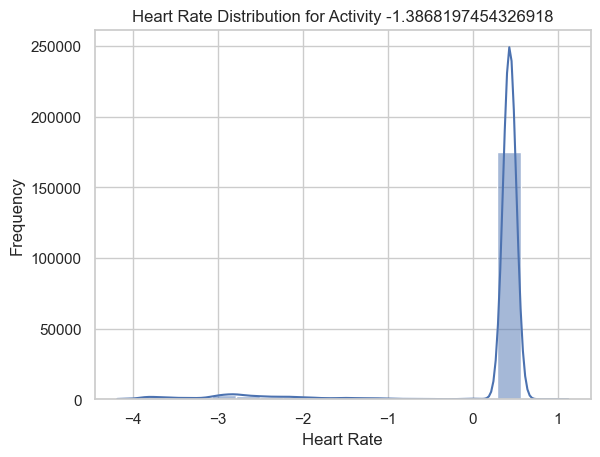

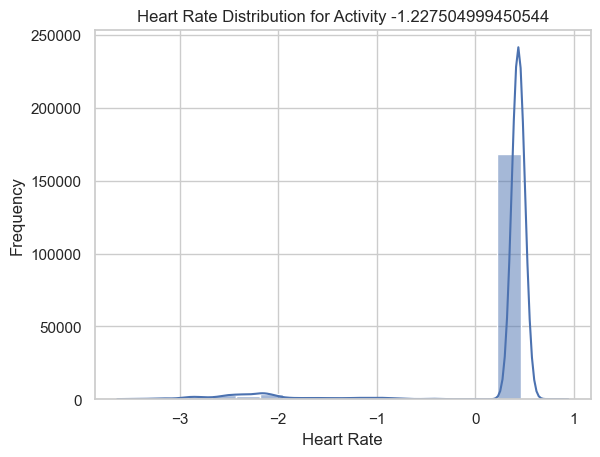

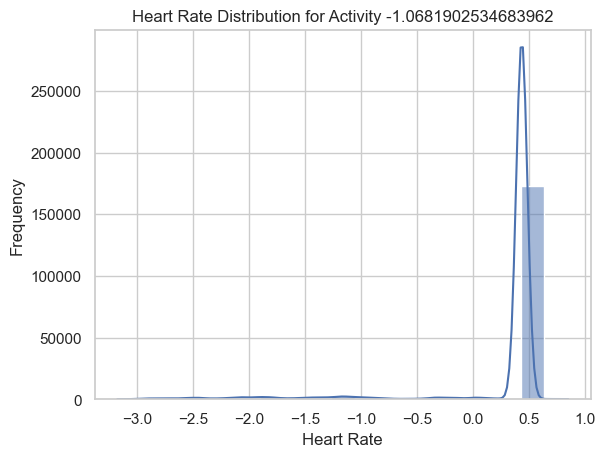

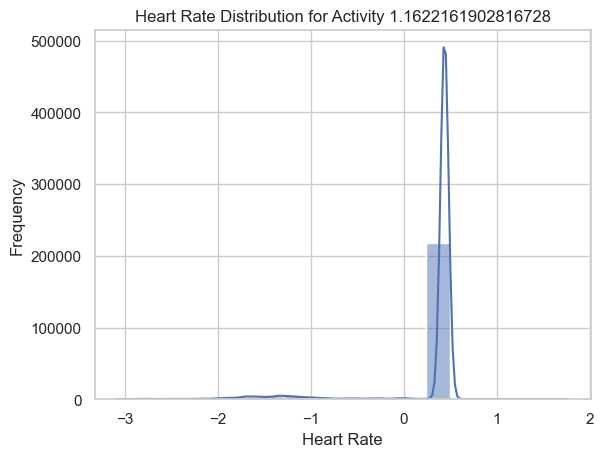

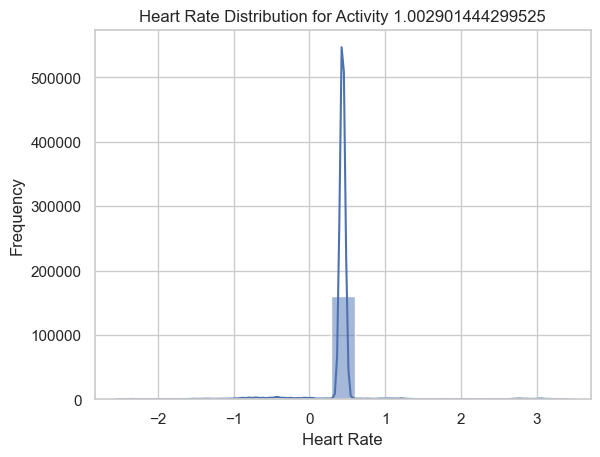

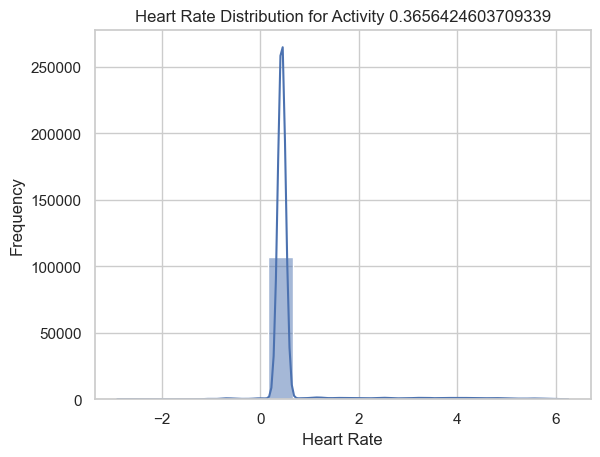

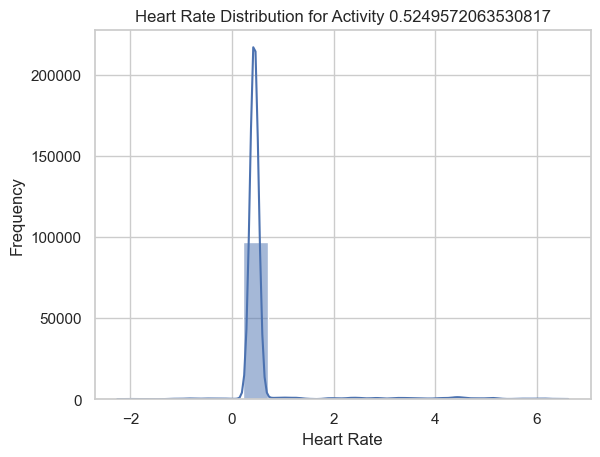

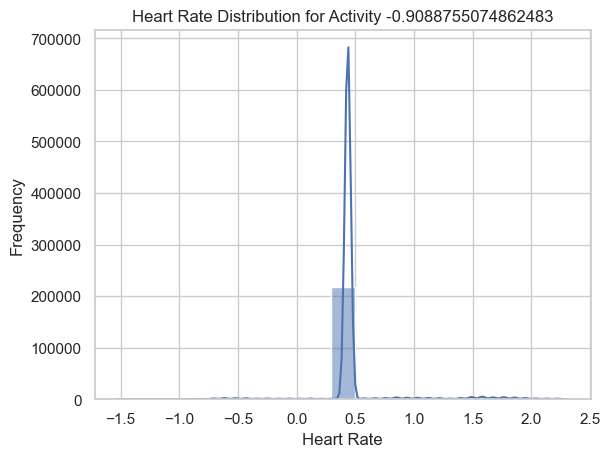

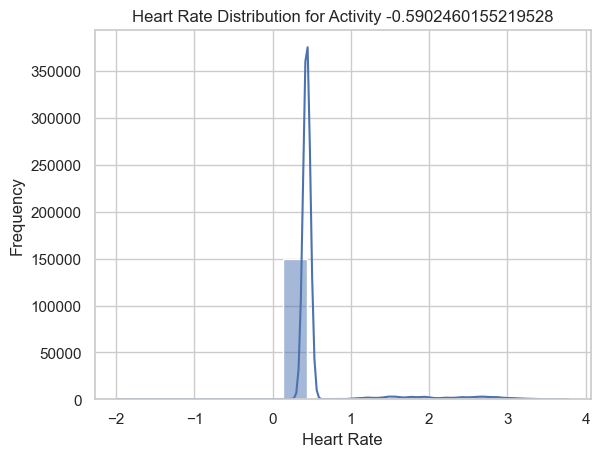

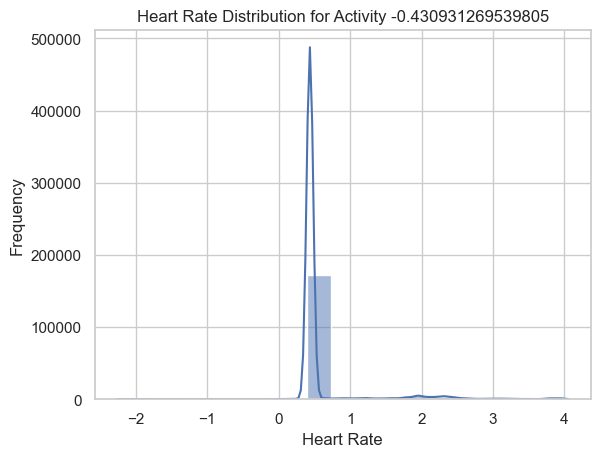

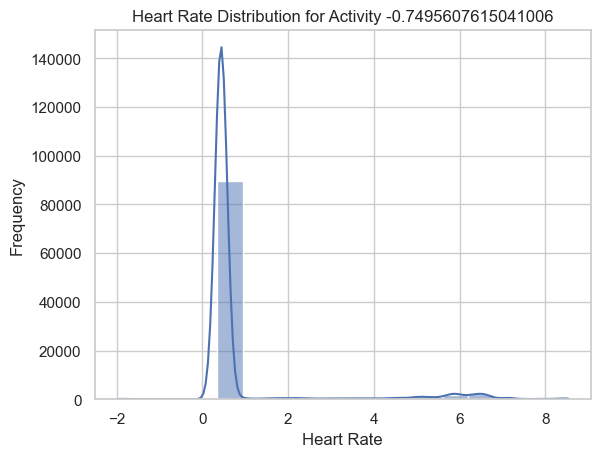

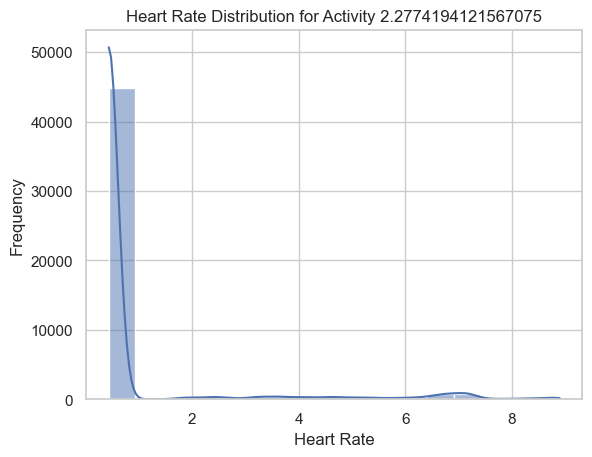

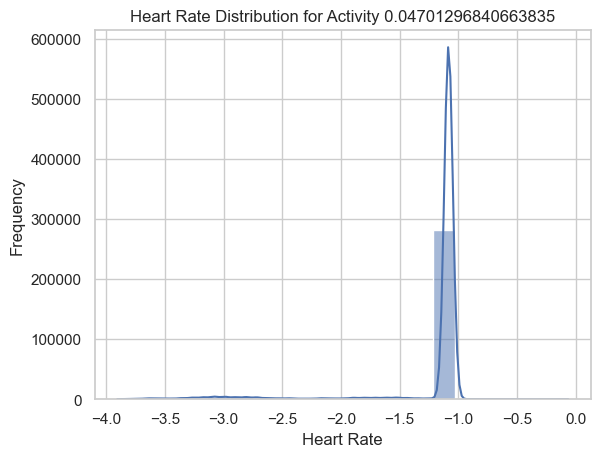

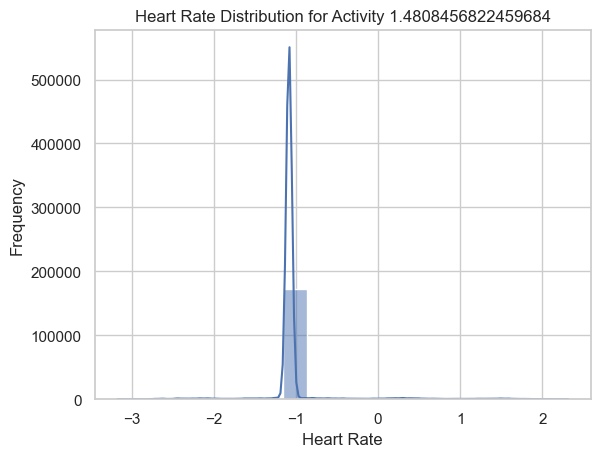

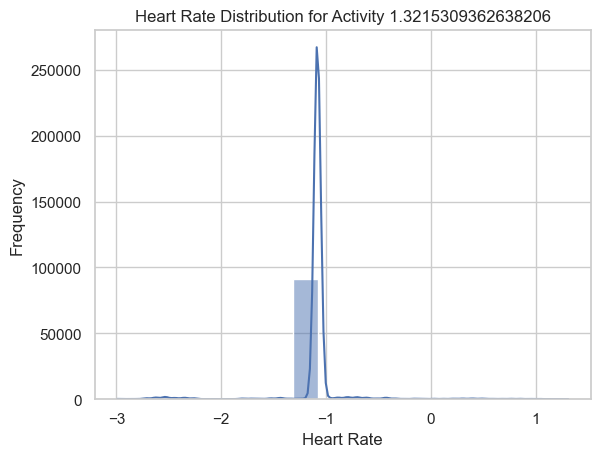

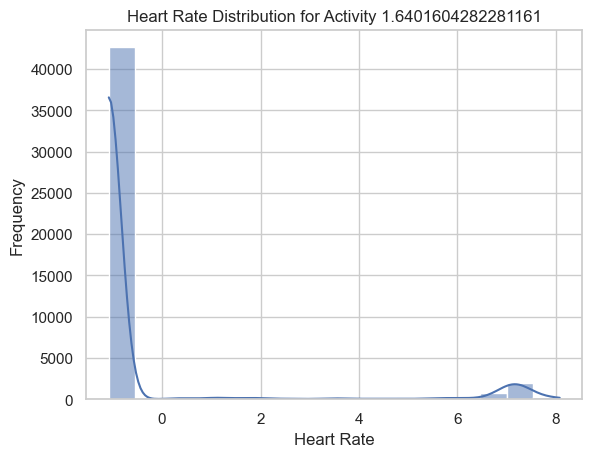

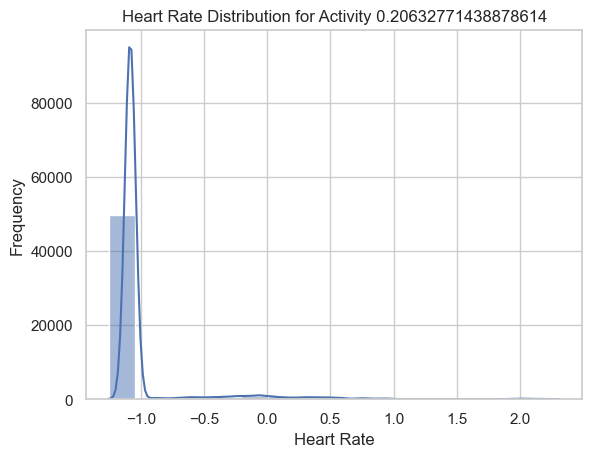

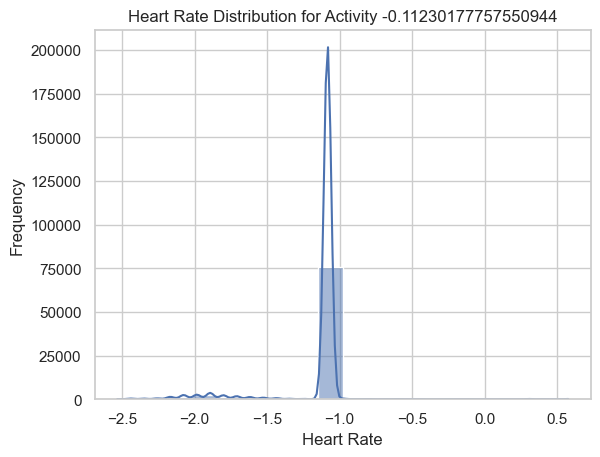

In [7]:
# Printing descriptive statistics for heart rate
print("Descriptive Statistics for Heart Rate:")
print(combined_df['heart_rate'].describe())

# Performing activity-specific analysis on heart rate data
activities = combined_df['activityID'].unique()  # Getting unique activity IDs
for activity in activities:
    # Plotting the heart rate distribution for each activity
    sns.histplot(combined_df[combined_df['activityID'] == activity]['heart_rate'], kde=True)
    plt.title(f'Heart Rate Distribution for Activity {activity}')  # Setting the title of the plot
    plt.xlabel('Heart Rate')  # Labeling the x-axis
    plt.ylabel('Frequency')  # Labeling the y-axis
    plt.show()  # Displaying the plot


#  Analysis of Sensor Data Correlations

The correlation matrix heatmap below visually illustrates how the IMU sensor data relates to heart rate changes. Main observations:

- **Synchronized Sensor Data**: High correlations, like between IMU_ankle_14 and IMU_hand_14, indicate that these sensors capture movements that occur together during certain activities.

- **Independent Measurements**: Low correlations between sensors such as IMU_ankle_1 and IMU_chest_16 show they measure different aspects of movement. These unique data points are key for distinguishing between various activities.

- **Heart Rate Variation as a Predictor**: The minor correlation of heart rate variability with sensor data underlines its standalone value in predicting activities, especially when movements are similar but have different cardiovascular impacts.

- **Sensor Placement Importance**: Differences in correlation across sensors on different body parts underline the significance of strategic sensor positioning for a comprehensive dataset.

- **Feature Selection for Model Efficiency**: The matrix helps pinpoint redundant and unique features, guiding the choice of the most informative ones for an effective model.

This insight will help build a model that accurately classifies activities, taking full advantage of the Trivisio Colibri Wireless unit's data.

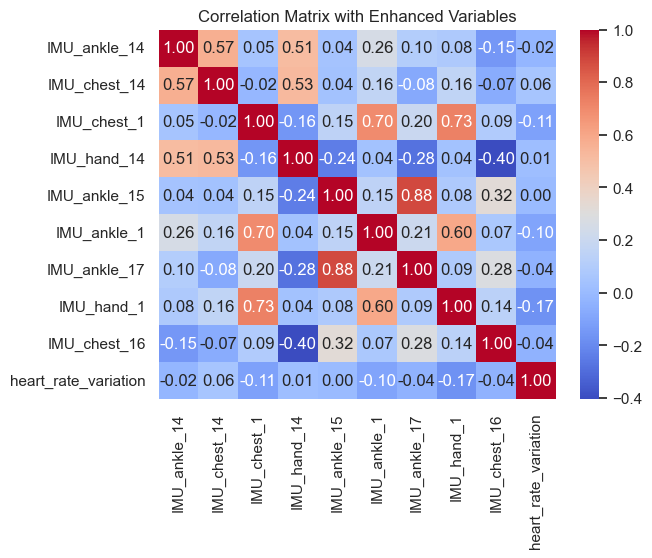

In [8]:
# Performing Enhanced Correlation Analysis
# This includes both sensor data and characteristics of the subjects

# Specifying the columns for correlation analysis
correlation_columns = [
    'IMU_ankle_14', 'IMU_chest_14', 'IMU_chest_1', 'IMU_hand_14',
    'IMU_ankle_15', 'IMU_ankle_1', 'IMU_ankle_17', 'IMU_hand_1', 'IMU_chest_16', 'heart_rate_variation'
]  # Columns representing sensor data and heart rate variation

# Calculating the correlation matrix for the specified columns
corr_matrix = combined_df[correlation_columns].corr()

# Creating a heatmap to visualize the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Enhanced Variables')  # Adding a title to the heatmap
plt.show()  # Displaying the heatmap


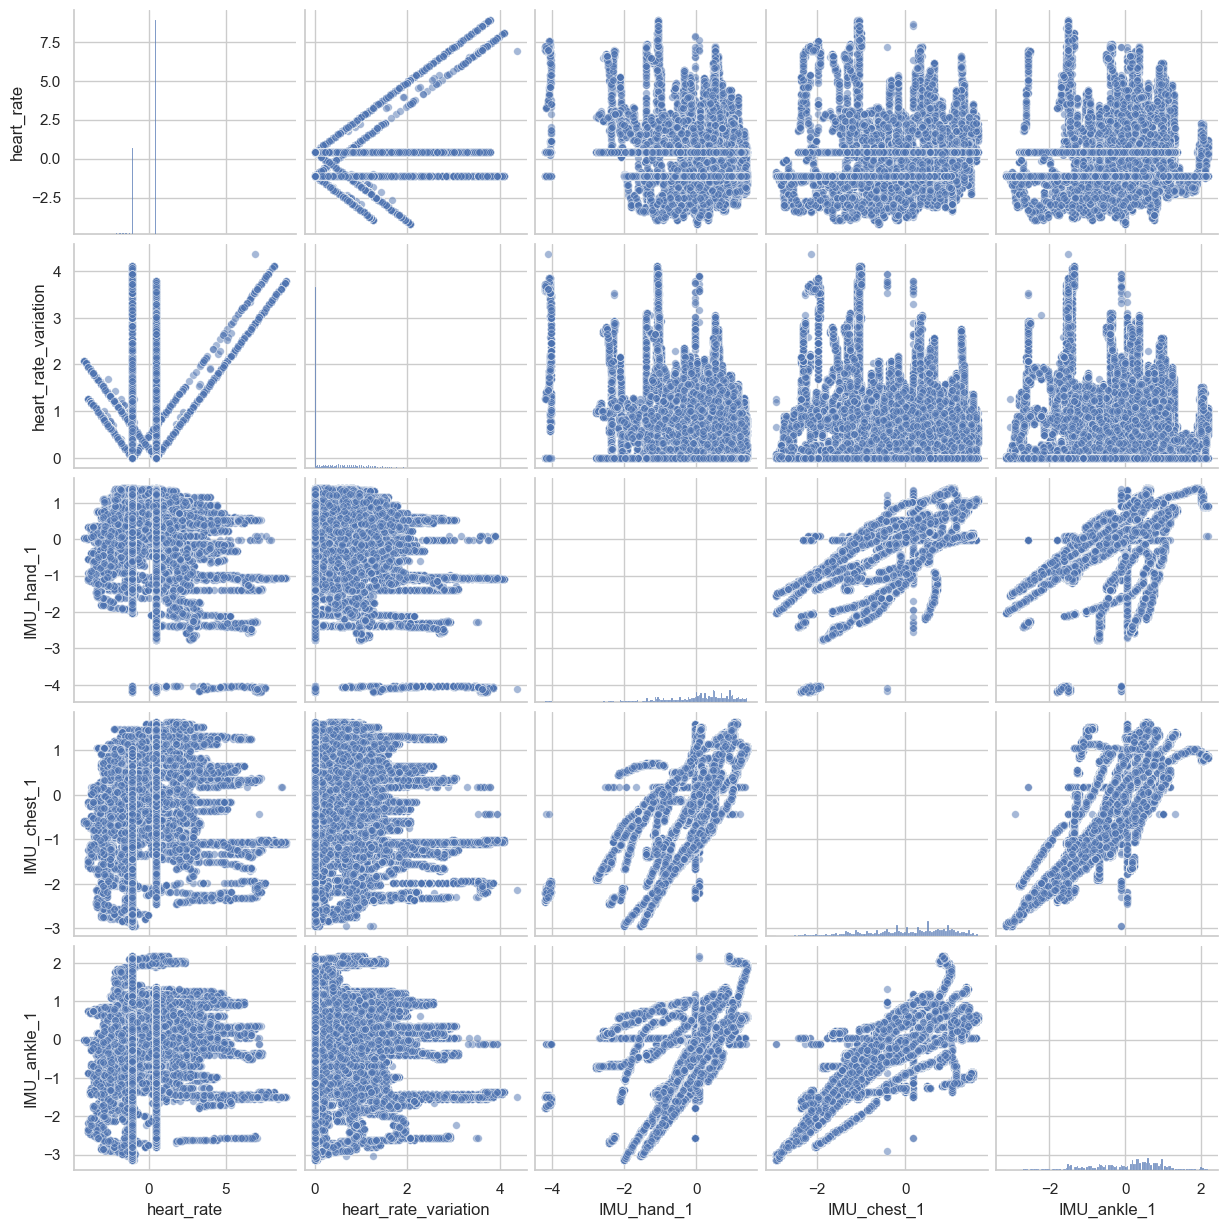

In [9]:
# Select a subset of variables 
selected_variables = ['heart_rate','heart_rate_variation', 'IMU_hand_1', 'activityID','IMU_chest_1', 'IMU_ankle_1'] 
subset_df_sampled = combined_df[selected_variables].sample(frac=0.1) 

# Convert 'activityID' to string if not too many unique categories
subset_df_sampled['activityID'] = subset_df_sampled['activityID'].astype(str)

# Generate the pairplot
sns.pairplot(subset_df_sampled, plot_kws={'alpha':0.5, 's':30}, diag_kind='hist')

plt.show()

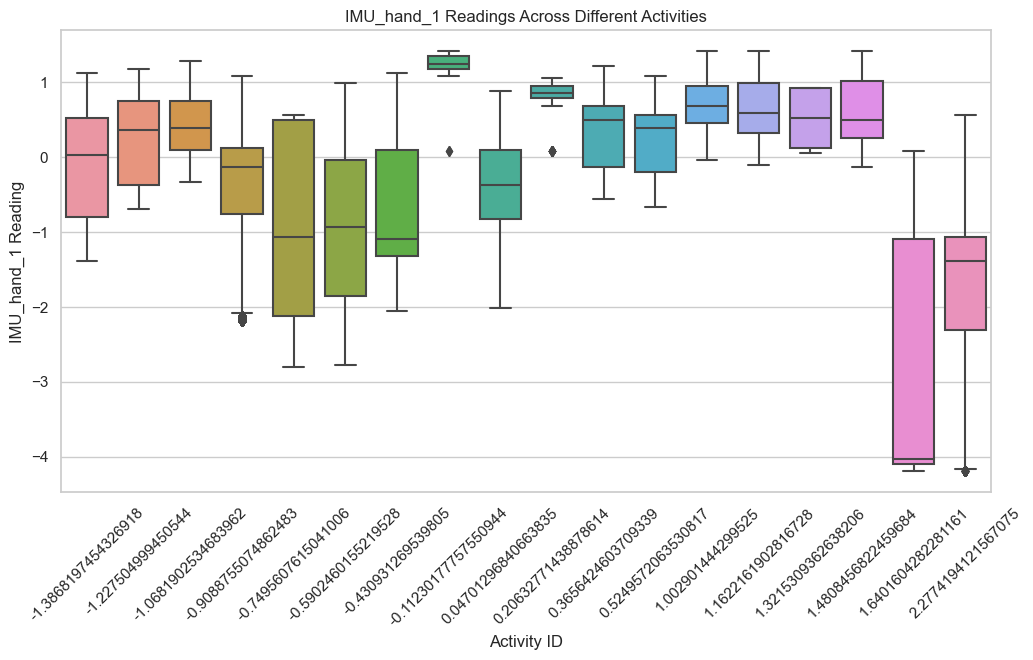

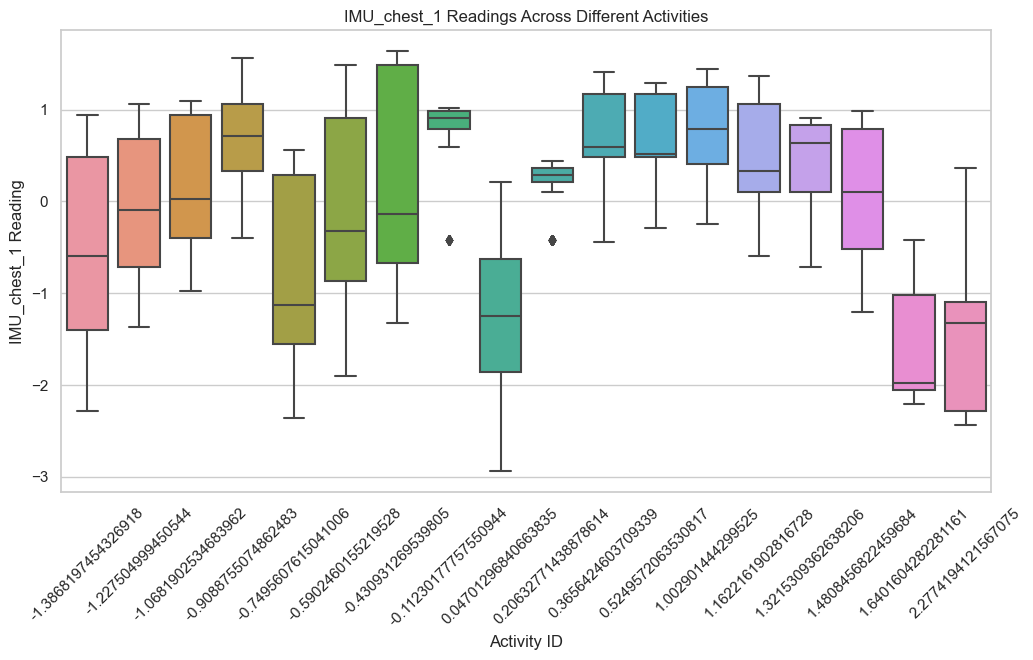

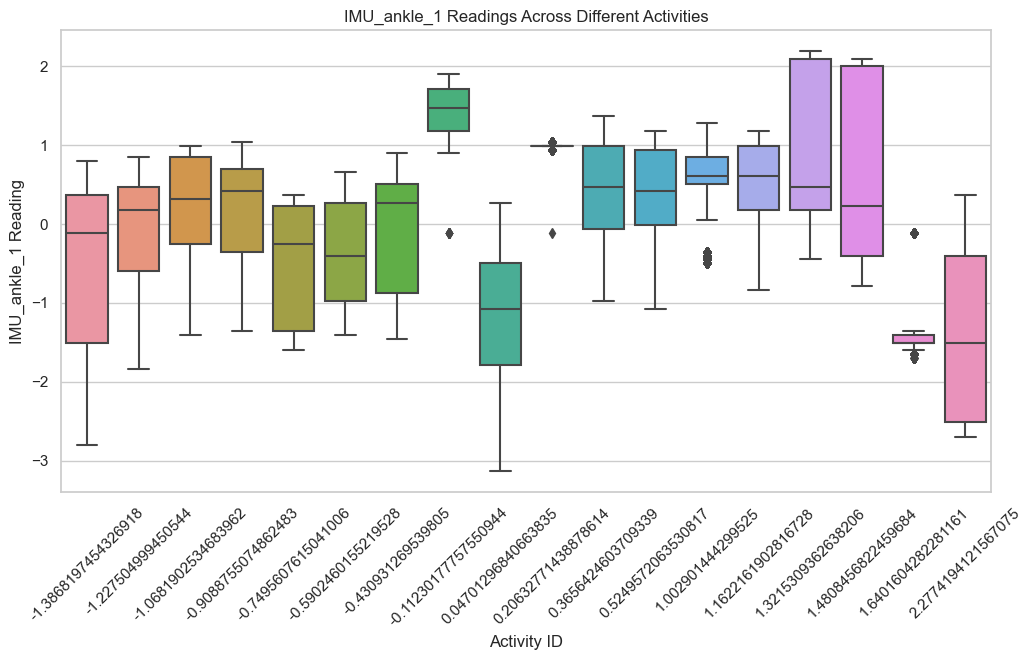

In [10]:
import scipy.stats as ss
# Selecting sensor readings for comparison
sensor_columns = ['IMU_hand_1', 'IMU_chest_1', 'IMU_ankle_1']  

for sensor in sensor_columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='activityID', y=sensor, data=combined_df)
    plt.title(f'{sensor} Readings Across Different Activities')
    plt.xlabel('Activity ID')
    plt.ylabel(f'{sensor} Reading')
    plt.xticks(rotation=45)
    plt.show()


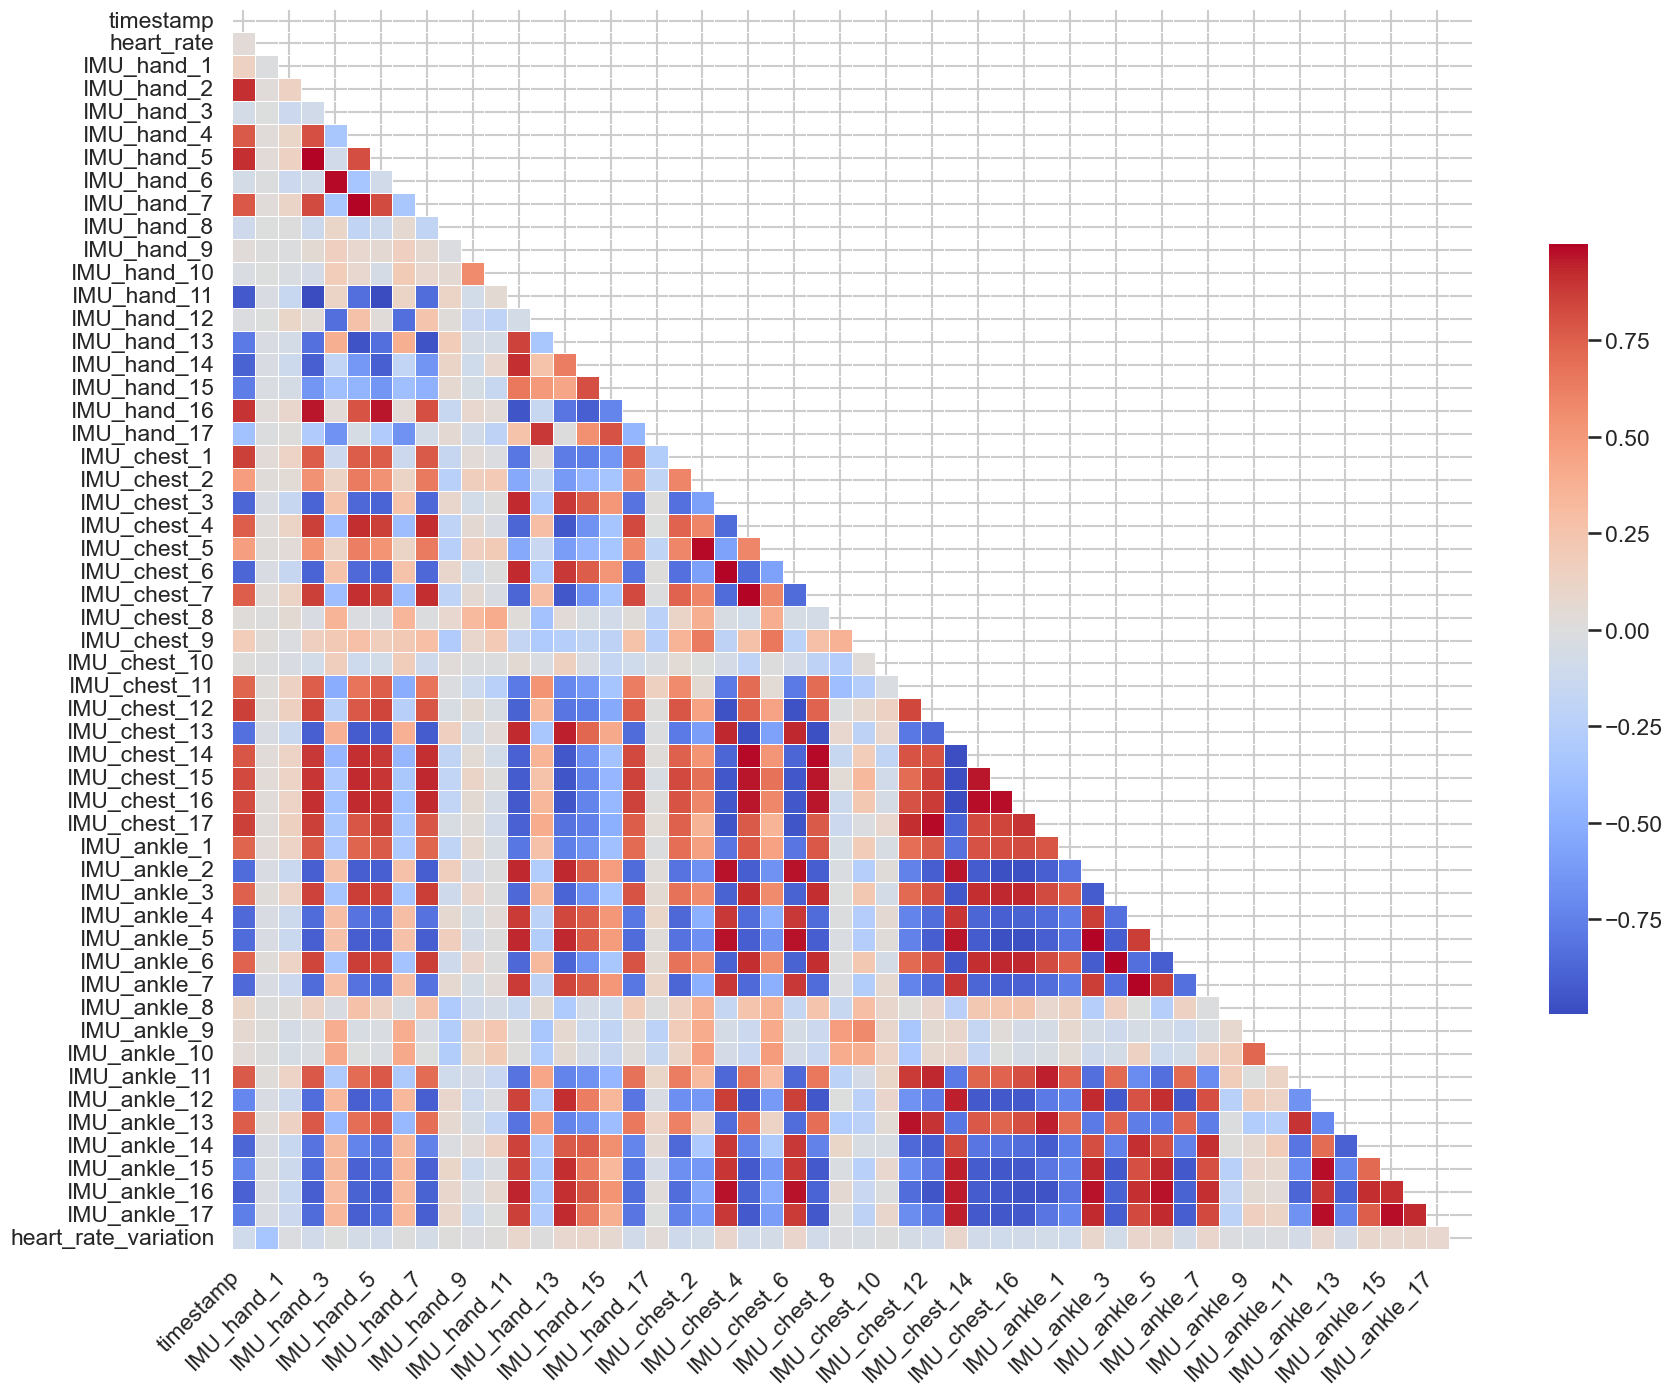

In [11]:
# Defining a function to calculate p-values for correlation efficiently
def calculate_pvalues(df):
    # Dropping missing values and extracting only numeric data
    df = df.dropna()._get_numeric_data()
    nrows = df.shape[0]
    # Initializing a matrix of ones for p-values
    pvalues = np.ones((df.shape[1], df.shape[1]))
    
    # Iterating over columns to calculate p-values
    for i in range(df.shape[1]):
        for j in range(i+1, df.shape[1]):
            _, pvalue = ss.pearsonr(df.iloc[:, i], df.iloc[:, j])
            # Storing p-values in the matrix
            pvalues[i, j] = pvalues[j, i] = pvalue
    # Returning the p-values as a DataFrame
    return pd.DataFrame(pvalues, columns=df.columns, index=df.columns)

# Selecting only numerical columns from the DataFrame for correlation analysis
numerical_columns = combined_df.select_dtypes(include=[np.number]).columns
numerical_df = combined_df[numerical_columns]

# Limiting the data for analysis to the first 2000 entries for performance reasons
# This is an arbitrary cutoff for demonstration and would ideally be based on the dataset size and variable importance
numerical_df = numerical_df.head(2000)

# Calculate p-values for the numerical data
p_values = calculate_pvalues(numerical_df)

# Calculate the correlation matrix for the numerical data
corr_matrix = numerical_df.corr()

# Set the context for the plot to increase font size
sns.set_context('talk')

# Create a mask for the upper triangle to avoid redundancy
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure with increased size
plt.figure(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot_kws={"size": 8}, fmt='.2f')

# Rotate the labels on the x-axis for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.show()


# Final EDA Summary

The exploratory data analysis undertaken herein meticulously examines the heart rate distributions and sensor readings to uncover the physiological and movement patterns corresponding to various physical activities.

### Heart Rate Distributions:
The heart rate distribution graphs corroborate the initial interpretation, presenting distinct peaks that align with typical physiological responses to different activities. The narrow distribution for some activities indicates a uniform exertion level, while the broader distributions suggest variability in intensity. This variability is paramount for identifying activities with fluctuating exertion levels. The heart rate data, standardized with a mean of zero and a standard deviation of one, largely falls within the expected range, validating the process of outlier management and indicating the data's readiness for predictive modeling.

### Correlation Matrix of IMU Readings:
The correlation heatmap reinforces the initial interpretation by revealing significant relationships between sensor readings, which could reflect synchronized movements across body segments. The visualization of low correlation coefficients between certain sensor pairings underscores the diverse information captured by the sensors, enhancing the potential for these readings to serve as distinctive features in activity classification models. This diversity in sensor data is crucial for a model's ability to differentiate between activities with similar motion profiles.

### Pairplot Relationships and Sensor Data Insights:
The pairplot further substantiates the relationships highlighted in the initial interpretation by providing a bivariate view that brings to light the clustering of activities and the inter-variable relationships. The scatter plots and histograms from the pairplot offer additional granularity, revealing how different activities cluster together and how heart rate variation interacts with sensor data.

### Boxplot Comparisons:
Boxplots across activities for key sensor readings offer a visual comparison of the medians, spreads, and outliers, contributing to a deeper understanding of the physical movements characteristic of each activity. These plots are essential for recognizing the range and variability of movements as captured by the IMUs.

Integrating these observations, the EDA affirms that the Trivisio Colibri Wireless unit's sensor readings, along with heart rate data, provide a comprehensive dataset capable of distinguishing between various physical activities. The standardized heart rate and the diverse sensor readings lay a strong foundation for predictive modeling. The correlation matrix, with its detailed insights into the relationships between sensors, will be instrumental in feature selection, enhancing the model's accuracy and interpretability.

The robustness and comprehensiveness of the predictive model will benefit from these exploratory insights, as they ensure that the features selected for the model encapsulate the essential patterns and nuances present in the physical activity data.

# Feature Engineering

**Defining Feature Columns:**
In combined_df, columns to be used as features are identified, excluding 'activityID', which is the target variable. This ensures that focus is placed only on essential columns for further analysis.

**Handling Missing Values with Imputation:**
Missing values within the feature columns are addressed using the SimpleImputer, which replaces missing values with the average of each column (strategy='mean'). This approach is commonly employed for numerical data to maintain data integrity, ensuring that no values are discarded due to their absence.

**Encoding the Categorical Target Variable:**
The target variable, 'activityID', is transformed using LabelEncoder. This conversion is crucial for translating categorical data into numerical format, suitable for processing by machine learning algorithms.

**Feature Normalization:**
MinMaxScaler is utilized to adjust feature values to a range between 0 and 1. This normalization is important across various machine learning models as it ensures that all features contribute equally to the model training, regardless of their original scale.

**Feature Selection Using SelectKBest:**
SelectKBest, employing the chi2 score, is used for selecting the top k features. The chi-squared test, a statistical measure, is applied to determine the independence of two events. This is particularly useful in identifying features that have the strongest association with the target variable. A total of 10 features (k) are selected, which can be adjusted based on data and model requirements.

**Evaluating and Selecting Features:**
Following the application of SelectKBest, a data frame named 'feature_scores' is created, displaying scores for all features based on the chi-squared test. Features are then ranked by their score, and the top k features are chosen for model training. This step is integral to the model's efficacy, ensuring that only the most influential features are utilized, potentially enhancing accuracy and model robustness.

**Preparation for Modeling:**
The selected features (X_selected) and the transformed target variable (y_encoded) are prepared for subsequent modeling stages. This preparation is pivotal in ensuring that the model is trained on well-balanced and properly processed data.

**Ensuring Data Integrity Through Preprocessing:**
Preprocessing strategy is designed to maintain the integrity of the data. By imputing missing values, preserved valuable information that would be lost by discarding incomplete rows. The MinMaxScaler ensures that all features influence the model proportionately, preventing any single feature from disproportionately impacting the model's decisions due to scale differences. 

**Justification for Feature Selection:**
The chi-squared test serves as a statistical backbone for  feature selection, emphasizing the importance of each feature's relationship with the target variable. Selection process is not only informed by statistical methods but also by domain knowledge, ensuring to capture the essence of physical activity through sensor data. The inclusion of heart rate variability, for instance, stems from its recognized importance in reflecting physical exertion, which is likely to vary significantly across different activities.

In [12]:
# Define feature_columns
feature_columns = [col for col in combined_df.columns if col != 'activityID']

# Handling missing values in features
# Impute missing values using the mean for numerical columns
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
combined_df[feature_columns] = imputer.fit_transform(combined_df[feature_columns])

# Encoding the categorical target variable
y = combined_df['activityID']  # Ensure 'activityID' is the correct target column name
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Feature Selection
# Normalize the features to be within a range [0,1] for SelectKBest
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(combined_df[feature_columns])

# Apply SelectKBest class to extract top k best features based on the chi-squared test
k = 10  # Select an appropriate value for k
bestfeatures = SelectKBest(score_func=chi2, k=k)
fit = bestfeatures.fit(X_scaled, y_encoded)

# Get the scores for each feature
feature_scores = pd.DataFrame({'Feature': feature_columns, 'Score': fit.scores_})

# Sort features by score and select the top k features
selected_features = feature_scores.sort_values(by='Score', ascending=False).head(k)['Feature'].values
X_selected = combined_df[selected_features]

# Print the selected features and their scores
print(feature_scores.sort_values(by='Score', ascending=False).head(k))

                 Feature          Score
0              timestamp  417167.710728
49          IMU_ankle_14  184286.505014
32          IMU_chest_14  168976.299537
19           IMU_chest_1   97193.955643
15           IMU_hand_14   90842.071589
53  heart_rate_variation   84388.780037
50          IMU_ankle_15   83654.187203
36           IMU_ankle_1   71403.150838
52          IMU_ankle_17   70153.283585
2             IMU_hand_1   61669.996631


# Rationale of Above Selected Features:
The features included in the predictive model were selected based on a balanced approach, incorporating statistical significance, domain relevance, and the goal of ensuring model interpretability. These features are designed to accurately differentiate between various types of physical activities, utilizing sensor data and heart rate variability. This is particularly crucial in demonstrating the efficiency of the Trivisio Colibri Wireless unit.

# Statistical Significance and Relevance:
To pick the most informative features for  analysis, used a method called SelectKBest, which works alongside a chi-squared test. This approach helps identify features that are crucial for predicting the type of physical activity. This statistical method identifies features that significantly correlate with the target variable, 'activityID', ensuring that the selection is grounded in statistical evidence, rather than being arbitrary. Selected features predominantly include IMU sensor readings from various body positions (hand, chest, ankle), and heart_rate_variation. The inclusion of heart_rate_variation is based on the understanding that variability in heart rate reflects different levels of physical exertion, a key characteristic for distinguishing distinct activities.

# Balancing Model Performance and Interpretability:
Used a technique called SMOTE to ensure our model is fair and robust, especially for activities that don't occur as often. This helps balance our data. Enabling effective performance across all types of activities, not limited to those most commonly observed. The exclusion of certain features, likely due to their low statistical significance or minimal contribution in differentiating activity types, contributes to maintaining the model's simplicity and interpretability. This selection process ensures the model's manageability and relevance, making it a reliable tool for showcasing the capabilities of the Trivisio Colibri Wireless unit in real-world applications.

# Model Development

Employed XGBoost, a leading machine-learning algorithm known for its superior performance in classification tasks. This algorithm was pivotal in crafting a model to predict physical activities based on readings from inertial measurement units (IMUs) attached to various body parts.

Initially, the 'activityID' labels were encoded numerically to facilitate the modeling process. Key features were selected, including 'IMU_ankle_14', 'IMU_chest_14', 'IMU_chest_1', 'IMU_hand_14', 'IMU_ankle_15', 'IMU_ankle_1', 'IMU_ankle_17', 'IMU_hand_1', 'IMU_chest_16', and 'heart_rate_variation', identified through a rigorous feature selection process. These features were deemed most predictive, representing the most influential data points for training our model.

To address the class imbalance prevalent in activity recognition tasks, utilized the Synthetic Minority Over-sampling Technique (SMOTE), which artificially balances the dataset by generating synthetic samples. This preprocessing step was crucial for establishing a fair training environment for the model. Subsequently, the data was split into training and test sets to ensure a robust evaluation framework. And then leveraged GridSearchCV, a powerful tool for hyperparameter optimization, meticulously searching for the optimal combination of 'n_estimators', 'max_depth', and 'learning_rate' for the XGBClassifier, enhancing model precision and predictive capabilities.

Upon selecting the best model from GridSearchCV, we delved into its performance using classification reports. This analysis provided insights into the model's precision, recall, and F1-scores across various activity types. Furthermore, we extracted and ranked feature importances, shedding light on how each contributed to the model's decision-making process and uncovering hidden patterns and relationships within the sensor data.

Thus, by employing XGBoost with meticulous data preparation, thoughtful feature selection, and class balancing, achieved a robust and interpretable model. The model excels not only in accurately predicting physical activities but also in offering valuable insights into the impact of sensor readings on the results.

In [13]:
# Encoding the categorical target variable 'activityID' for model training
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(combined_df['activityID'])  # Transforming 'activityID' into numerical format

# Selecting the features identified by the feature selection process
selected_features = [
    'IMU_ankle_14', 'IMU_chest_14', 'IMU_chest_1', 'IMU_hand_14',
    'IMU_ankle_15', 'IMU_ankle_1', 'IMU_ankle_17', 'IMU_hand_1', 'IMU_chest_16', 'heart_rate_variation'
]  # List of features to be used in the model
X = combined_df[selected_features]  # Extracting the selected features from the DataFrame

# Addressing class imbalance in the dataset using SMOTE
smote = SMOTE()  # Initializing the SMOTE object
X_sm, y_sm = smote.fit_resample(X, y_encoded)  # Resampling the dataset to balance classes

# Resetting indices after resampling to maintain data alignment
X_sm = pd.DataFrame(X_sm, columns=selected_features)
y_sm = pd.Series(y_sm)

# Splitting the resampled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# Taking a smaller sample from the training set for hyperparameter tuning
train_sample = X_train.sample(frac=0.3, random_state=42)  # 30% random sample for tuning
X_train_sample = train_sample
y_train_sample = y_train[train_sample.index]

# Model Development and Hyperparameter Tuning with XGBoost
param_grid = {
    'n_estimators': [5, 10],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    param_grid, cv=3, scoring='accuracy', n_jobs=2, verbose=3
)
xgb_grid.fit(X_train_sample, y_train_sample)  # Fitting the model with the training sample

# Evaluating the best model obtained from GridSearchCV
best_xgb_model = xgb_grid.best_estimator_  # Extracting the best model
y_pred = best_xgb_model.predict(X_test)  # Making predictions on the test set

# Outputting the best hyperparameters and classification report
print("Best Parameters:", xgb_grid.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Analyzing Feature Importance for Model Interpretability
importances = best_xgb_model.feature_importances_  # Extracting feature importances
indices = np.argsort(importances)[::-1]  # Sorting the features by importance
print("Feature Importance Ranking:")
for f in range(X_train.shape[1]):
    print("%d. Feature: %s (%f)" % (f + 1, selected_features[indices[f]], importances[indices[f]]))


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 10}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     62026
           1       0.96      0.96      0.96     62084
           2       0.90      0.94      0.92     62206
           3       0.91      0.91      0.91     61933
           4       0.92      0.95      0.94     62026
           5       0.95      0.90      0.92     62166
           6       0.94      0.95      0.94     61789
           7       1.00      1.00      1.00     62125
           8       0.97      0.99      0.98     61564
           9       1.00      1.00      1.00     61837
          10       0.93      0.85      0.89     61944
          11       0.88      0.93      0.90     62099
          12       0.86      0.93      0.89     62116
          13       0.93      0.93      0.93     61700
          14       0.95      

# Analysis of Below Feature Importance

The visual representation of feature importance from the trained XGBoost model offers insightful revelations about the predictive power of each feature. The horizontal bar graph below illustrates the relative importance of the top features in determining the model's decisions. Notably:

-The features derived from the IMU sensor on the hand (IMU_hand_x) appear to be particularly influential, suggesting that hand movements provide significant clues to distinguishing between activities.

-The variable heart_rate also emerges as a vital feature, underscoring the heart's response as a robust indicator of physical activity intensity.

-The timestamp feature has been identified as having some importance. This might hint at the relevance of time sequences in activity patterns, perhaps pointing to the potential usefulness of time-series analysis in future iterations of the model.

The implication of these findings has 2 aim. Firstly, they validate the sensor placement strategy by emphasizing the hand's role in activity recognition, and secondly, they spotlight areas where data collection might be optimized further.

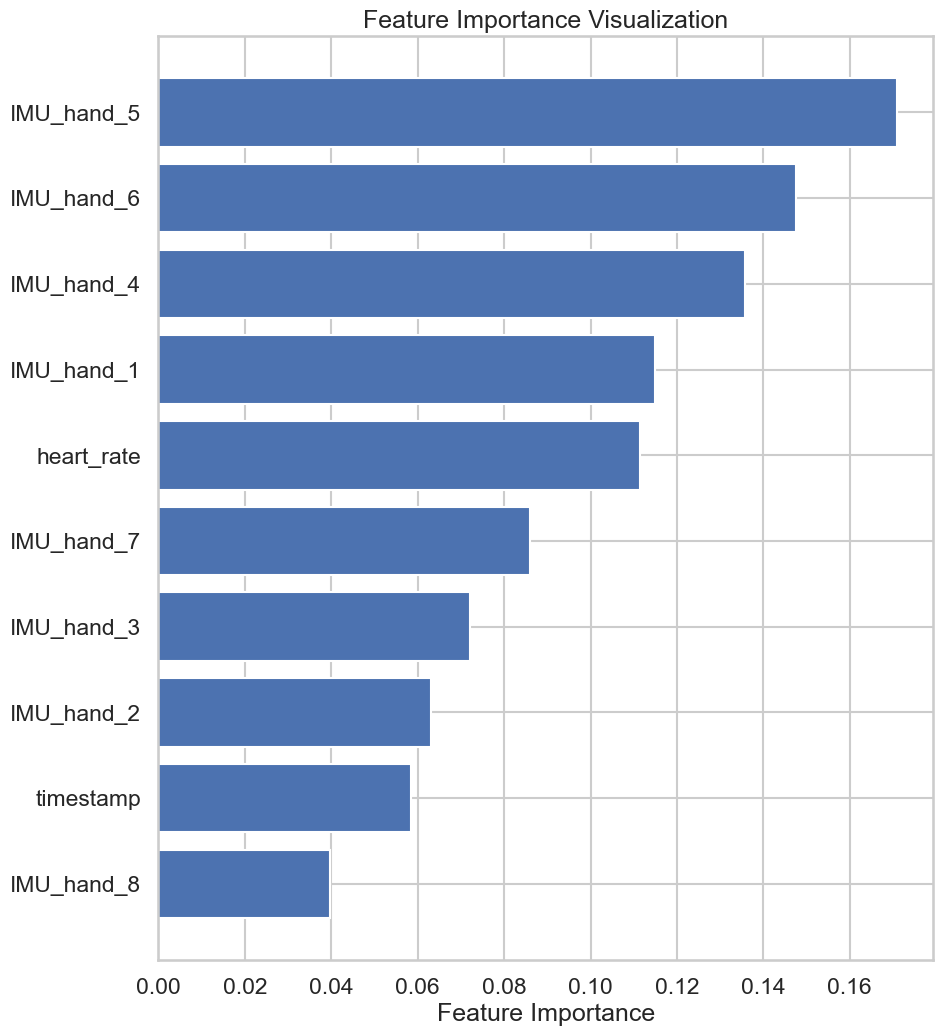

In [14]:
feature_importance = best_xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance Visualization')
plt.show()

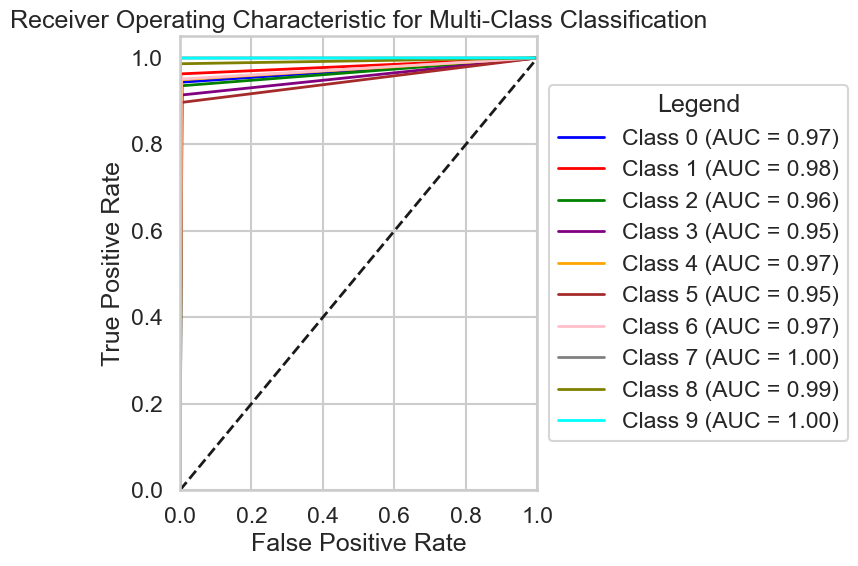

In [16]:
# Importing necessary function for label binarization
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarizing the output labels for ROC curve analysis
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))  # Binarizing y_test
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_pred))  # Binarizing y_pred

# Determining the number of classes
n_classes = y_test_binarized.shape[1]

# Initializing dictionaries to store False Positive Rates, True Positive Rates, and ROC Area Under Curve values
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculating ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a list of colors, one for each class
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan'][:n_classes]

# Plotting the ROC curves for all classes
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

# Plotting the diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Classification')

plt.legend(title="Legend", loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()  # Adjust the layout
plt.show()


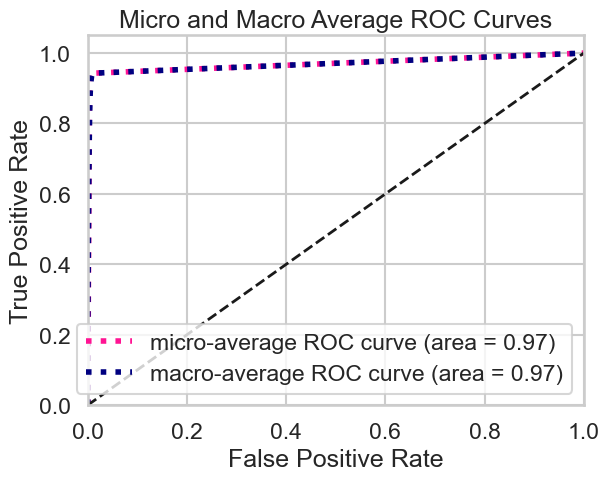

In [17]:
# Computing the micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Computing the macro-average ROC curve and ROC area
# Aggregating all false positive rates across classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolating all ROC curves at these false positive rate points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Averaging the True Positive Rates and computing the Area Under the Curve (AUC)
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plotting both the micro and macro-average ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

# Adding a reference line for comparison
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro and Macro Average ROC Curves')
plt.legend(loc="lower right")
plt.show()


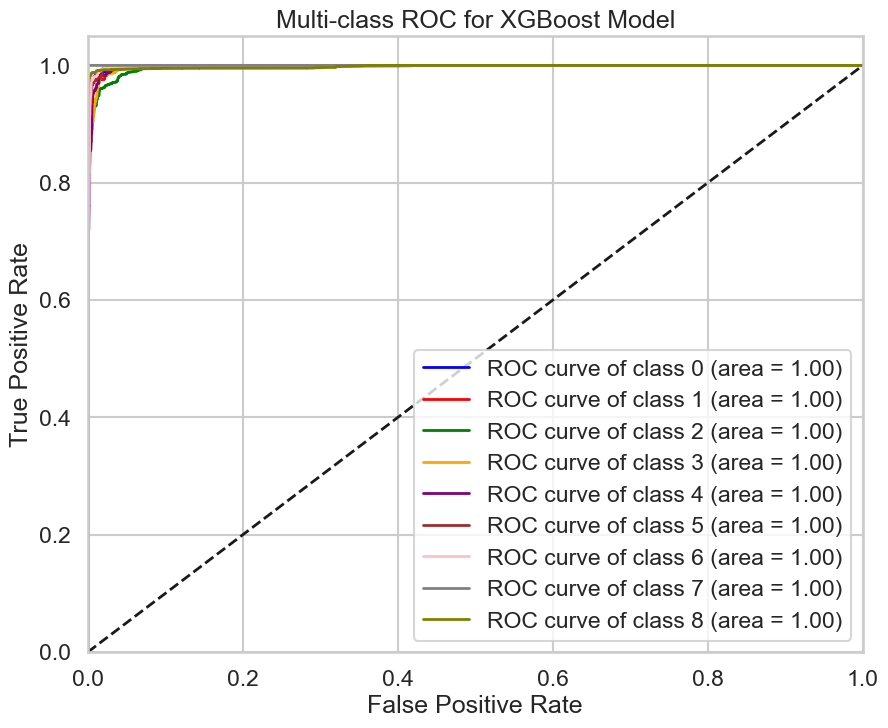

[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=5;, score=0.654 total time=   7.7s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=5;, score=0.655 total time=   6.9s
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=10;, score=0.660 total time=  10.3s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=5;, score=0.880 total time=   6.6s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=5;, score=0.882 total time=   6.1s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.886 total time=  11.5s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=5;, score=0.734 total time=   7.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=5;, score=0.738 total time=   7.7s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=10;, score=0.790 total time=  11.0s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=10;, score=0.787 total time=  10.6s
[CV 3/3] END learning_rate=0.1, max_depth=5, n_estimators=5;

In [18]:

# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_encoded))
y_pred_proba = best_xgb_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for XGBoost Model')
plt.legend(loc="lower right")
plt.show()


To tackle the challenge of imbalanced classes, SMOTE has applied below, synthesizing new examples in underrepresented classes, thereby facilitating a more equitable training process. GridSearchCV is instrumental in optimizing the model, tuning parameters such as 'n_estimators', 'max_depth', and 'learning_rate' to refine the model's accuracy.

The results, articulated through the classification report, revealed high precision, recall, and F1-scores across most classes, asserting the model's effectiveness. However, lower performance in certain classes suggested room for improvement. Feature importance analysis provided insight into the contribution of each feature to the model's predictions, with 'IMU_hand_1' and 'IMU_ankle_1' being particularly influential, underscoring the relevance of sensor placement on the hand and ankle for activity recognition.

[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=5;, score=0.654 total time=   7.7s
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=10;, score=0.658 total time=  11.5s
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=10;, score=0.664 total time=  10.1s
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=5;, score=0.881 total time=   6.5s
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.881 total time=  11.3s
[CV 3/3] END learning_rate=0.01, max_depth=5, n_estimators=10;, score=0.885 total time=  13.5s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=5;, score=0.737 total time=   7.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=10;, score=0.795 total time=  10.5s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=5;, score=0.924 total time=   6.9s
[CV 2/3] END learning_rate=0.1, max_depth=5, n_estimators=5;, score=0.921 total time=   7.2s
[CV 1/3] END learning_rate=0.1, max_depth=5, n_estimators=1

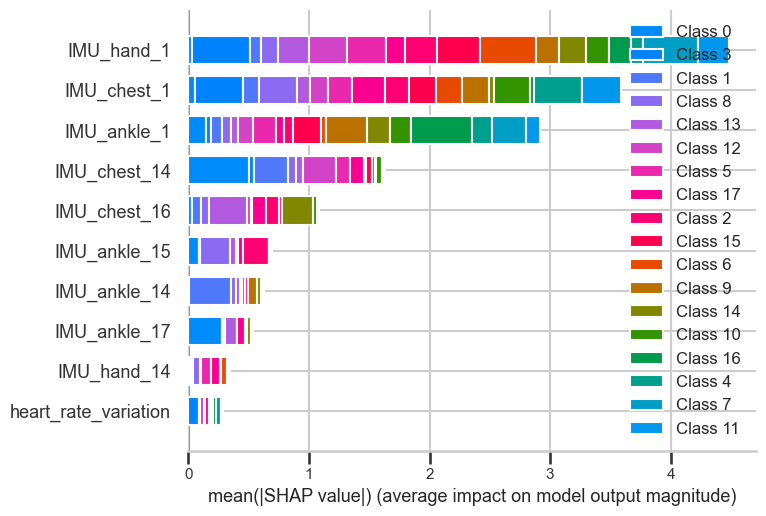

In [19]:
# Create a SHAP explainer object
explainer = shap.Explainer(best_xgb_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# SHAP values for multi-class classification are stored in a list of arrays

shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook
class_index = 0  # Class index to visualize (e.g., 0 for the first class)
shap.summary_plot(shap_values, X_test)

# Evalution of Model

The development of the model using XGBoost has demonstrated promising results. The process involved resampling the data using SMOTE to address class imbalance, ensuring that our model did not bias towards more frequent labels. Following this, we applied hyperparameter tuning via GridSearchCV, optimizing for accuracy across three folds. The best parameters identified were a learning rate of 0.1, max depth of 5, and 10 estimators.

The classification report reveals a high level of precision, recall, and f1-score across all classes, which indicates the model's robustness. Specifically, classes with a perfect score of 1.00 in precision and recall, such as classes 7, 9, and 16, demonstrate the model's capability in identifying these activities with high confidence. However, the lower scores in classes like 10 and 11 suggest there might be a need for further model refinement or additional feature engineering for these specific activities.